In [1]:
using Pkg
envpath = expanduser("~/envs/deeptraining/")
Pkg.activate(envpath)

# libs
using Images
using DataFrames
using CSV
using Random
using MLUtils: splitobs, randobs

  Activating project at `~/envs/deeptraining`


In [2]:
# input folders
datasetPath  = "/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/"
imagesPath   = datasetPath * "JPEGImages/"
masksPath    = datasetPath * "SegmentationClass/"
cowslist     = datasetPath * "ImageSets/Main/cow_trainval.txt"

# output folders
workpath = pwd() * "/"
workpath = replace(workpath, homedir() => "~")

"~/projects/deeptraining/dataset/"

In [3]:
# dfcow
dfcow = CSV.read(expanduser(cowslist), header=false, DataFrame)

# split columns
dfcow = DataFrame(filename=first.(split.(dfcow[:,1], ' ')), label=last.(split.(dfcow[:,1], ' ')))
dfcow.filename = dfcow.filename .|> String
dfcow.label = map(x -> x == "-1" ? 0 : 1, dfcow.label)

# add new column "segmented" to data frame
dfcow.segmented = zeros(Int, size(dfcow, 1))
first(dfcow, 5)

Row,filename,label,segmented
,String,Int64,Int64
1,2008_000002,0,0
2,2008_000003,0,0
3,2008_000007,0,0
4,2008_000008,0,0
5,2008_000009,1,0


In [4]:
# populate segmented column
segfiles = readdir(expanduser(masksPath))

dfcow.segmented = 
    [ifelse(row.label == 1 && row.filename * ".png" in segfiles, 1, 0) 
    for row in eachrow(dfcow)]

sum(dfcow.segmented)

104

In [5]:
# split segmented dataset in train, valid, test
df = dfcow[dfcow.segmented .== 1, :]
N = size(df, 1)
Random.seed!(1234)   # MUST NOT CHANGE
indtrain, indval, indtest = splitobs(1:N, at = (0.70, 0.20), shuffle = true)
dftrain_seg = df[indtrain, :]
dfvalid_seg = df[indval, :]
dftest_seg  = df[indtest, :]

size(dftrain_seg), size(dfvalid_seg), size(dftest_seg)

((73, 3), (21, 3), (10, 3))

In [6]:
# make non segmented dataset with same size as segmented
# then, split in train, valid, test
df = dfcow[dfcow.segmented .== 0, :]
Random.seed!(1234)   # MUST NOT CHANGE
sampled_df = randobs(df, N)
indtrain, indval, indtest = splitobs(1:N, at = (0.70, 0.20), shuffle = true)
dftrain_noseg = sampled_df[indtrain, :]
dfvalid_noseg = sampled_df[indval, :]
dftest_noseg  = sampled_df[indtest, :]

size(dftrain_noseg), size(dfvalid_noseg), size(dftest_noseg)

((73, 3), (21, 3), (10, 3))

In [7]:
# merge datasets
dftrain = vcat(dftrain_seg, dftrain_noseg)
dfvalid = vcat(dfvalid_seg, dfvalid_noseg)
dftest  = vcat(dftest_seg, dftest_noseg)

size(dftrain), size(dfvalid), size(dftest)

((146, 3), (42, 3), (20, 3))

In [8]:
# make X addresses
dftrain.X = imagesPath .* dftrain.filename .* ".jpg"
dfvalid.X = imagesPath .* dfvalid.filename .* ".jpg"
dftest.X  = imagesPath .* dftest.filename .* ".jpg"

# make y addresses
dftrain.y = 
    [row.segmented == 1 ? masksPath .* row.filename .* ".png" : "" for row in eachrow(dftrain)]
dfvalid.y =
    [row.segmented == 1 ? masksPath .* row.filename .* ".png" : "" for row in eachrow(dfvalid)]
dftest.y =
    [row.segmented == 1 ? masksPath .* row.filename .* ".png" : "" for row in eachrow(dftest)];

# remove "filename" column
dftrain = select!(dftrain, [:X, :y, :label, :segmented])
dfvalid = select!(dfvalid, [:X, :y, :label, :segmented])
dftest  = select!(dftest, [:X, :y, :label, :segmented]);

In [9]:
first(dftrain, 3)

Row,X,y,label,segmented
,String,String,Int64,Int64
1,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2009_002422.jpg,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/SegmentationClass/2009_002422.png,1,1
2,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2008_000073.jpg,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/SegmentationClass/2008_000073.png,1,1
3,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2009_003542.jpg,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/SegmentationClass/2009_003542.png,1,1


In [10]:
last(dftrain, 3)

Row,X,y,label,segmented
,String,String,Int64,Int64
1,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2011_000232.jpg,,0,0
2,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2008_001694.jpg,,0,0
3,/scratch/cirobr/datasets/pascalvoc/VOCdevkit/VOC2012/JPEGImages/2011_002110.jpg,,0,0


In [11]:
# save datasets
CSV.write(expanduser(workpath) * "dftrain-coi.csv", dftrain)
CSV.write(expanduser(workpath) * "dfvalid-coi.csv", dfvalid)
CSV.write(expanduser(workpath) * "dftest-coi.csv", dftest)

"/home/cirobr/projects/deeptraining/dataset/dftest-coi.csv"

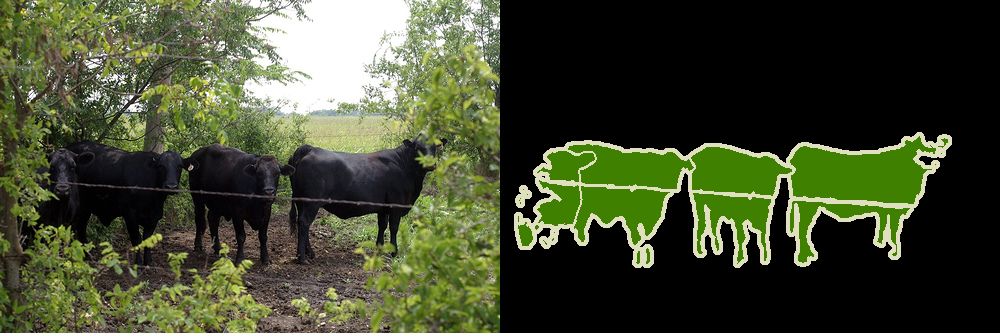

In [12]:
# checkpoint
dftrain = CSV.read(expanduser(workpath) * "dftrain-coi.csv", DataFrame)
df = dftrain[dftrain.segmented .== 1, :]

k = rand(1:size(df, 1))
img = Images.load(expanduser(df.X[k]))
msk = Images.load(expanduser(df.y[k]))
mosaicview([img, msk]; nrow=1)